<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

# <p style="font-size:100%; text-align:left; color:#444444;">Exploratory Data Analysis (EDA)</p>

# <p style="font-size:100%; text-align:left; color:#444444;">Table of Contents:</p>
* [1. EDA](#1)
  * [1.1 Rentals Data - Moby Bikes](#1.1)
  * [1.2 Weather Data - Met Éireann](#1.2)
  * [1.3 Unusual Observations analysis](#1.2)
* [2. Discrete Analysis (Count Data)](#2)
  * [2.1 Overdispersion](#2.1)
  * [2.2 Zero-inflated](#2.2)
* [2. Probability distribution vs Time Series](#2)
  * [2.1 Time series analysis](#2.1)
  * [2.2 Zero-inflated analysis](#2.2)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import scipy.stats as stats
from patsy import dmatrices

# statsmodels
from statsmodels.stats import diagnostic as diag
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
%reload_ext watermark
%watermark -a "Leandro Pessini" -n -u -v -iv -w

Author: Leandro Pessini

Last updated: Sun May 08 2022

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 8.3.0

matplotlib : 3.4.2
sys        : 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) 
[Clang 11.1.0 ]
scipy      : 1.8.0
numpy      : 1.21.1
seaborn    : 0.11.1
statsmodels: 0.13.2
pandas     : 1.3.0

Watermark: 2.3.0



In [3]:
hourly_data = pd.read_csv('../data/processed/hourly_data.csv')
hourly_rentals = pd.read_csv('../data/processed/hourly_rentals.csv')
all_data = pd.read_csv('../data/processed/all_data.csv')
rentals = pd.read_csv('../data/interim/new_features_rentals.csv')
hourly_data.head()

,rain,temp,rhum,wdsp,date,hour,day,month,year,holiday,...,season,peak,timesofday,rainfall_intensity,wind_bft,wind_speed_group,temp_r,temp_bin,rhum_bin,count
0,0.0,0.1,98,4,2021-03-01,0,1,3,2021,False,...,Winter,False,Night,no rain,2,Calm / Light Breeze,0,0.0,4.0,0
1,0.0,-1.1,98,3,2021-03-01,1,1,3,2021,False,...,Winter,False,Night,no rain,2,Calm / Light Breeze,-1,0.0,4.0,0
2,0.0,-1.2,98,4,2021-03-01,2,1,3,2021,False,...,Winter,False,Night,no rain,2,Calm / Light Breeze,-1,0.0,4.0,1
3,0.0,-0.9,100,5,2021-03-01,3,1,3,2021,False,...,Winter,False,Night,no rain,2,Calm / Light Breeze,-1,0.0,4.0,0
4,0.0,0.0,100,6,2021-03-01,4,1,3,2021,False,...,Winter,False,Night,no rain,2,Calm / Light Breeze,0,0.0,4.0,0


In [4]:
# EDA libraries
# from pandas_profiling import ProfileReport
# from dataprep.eda import create_report
# import sweetviz as sv

# Dataprep Report

# hourly_data_report = create_report(hourly_data, title='Hourly Data Report', progress=False)
# hourly_data_report.save('../reports/dataprep/hourly_data_report')
# hourly_rentals_report = create_report(hourly_rentals, title='Hourly Data Report (Only Rentals)', progress=False)
# hourly_rentals_report.save('../reports/dataprep/hourly_rentals_report')

# Pandas Profiling

# profile = ProfileReport(hourly_data, title='Hourly Data', html={'style':{'full_width':True}})
# profile.to_file(output_file='../reports/pandas-profiling/hourly_data_report.html')

# profile = ProfileReport(hourly_rentals, title='Hourly Data Report (Only Rentals)', html={'style':{'full_width':True}})
# profile.to_file(output_file='../reports/pandas-profiling/hourly_rentals_report.html')

# to_notebook_iframe() will print in the jupyter notebook's cell
# profile.to_notebook_iframe()

# SweetViz

# hourlydata_sweetviz_report = sv.analyze(hourly_data, target_feat='count')
# hourlydata_sweetviz_report.show_html('../reports/sweetviz/hourly_data_report.html')

# hourlyrentals_sweetviz_report = sv.analyze(hourly_rentals, target_feat='count')
# hourlyrentals_sweetviz_report.show_html('../reports/sweetviz/hourly_rentals_report.html')

In [5]:
cat_vars_dict = {'holiday': 'category', 'dayofweek': 'category', 'working_day': 'category', 
            'season': 'category', 'peak': 'category', 'timesofday': 'category', 'rainfall_intensity': 'category',
            'rhum_bin': 'category', 'temp_bin': 'category', 'wind_bft': 'category', 'wind_speed_group': 'category'}

hourly_data = hourly_data.astype(cat_vars_dict)
hourly_rentals = hourly_rentals.astype(cat_vars_dict)

## Battery distribution

In [6]:
battery_dist_df = all_data.copy()

def group_battery_status(df):

    bins= [0,30,50,80,100]
    labels = ['< 30%','30% - 50%','50% - 80%','> 80%']
    df['battery_status'] = pd.cut(df['start_battery'], bins=bins, labels=labels, right=False)

    s = df.battery_status
    counts = s.value_counts()
    percent = s.value_counts(normalize=True)
    df_summary = pd.DataFrame({'counts': counts, 'per': percent}, labels)
    df_summary['per100'] = round((df_summary['per']*100),2).astype(str) + '%'
    
    return df_summary

battery_dist = group_battery_status(battery_dist_df)
battery_dist

,counts,per,per100
< 30%,2509,0.076862,7.69%
30% - 50%,5767,0.176669,17.67%
50% - 80%,14290,0.437766,43.78%
> 80%,10077,0.308703,30.87%


### Initial battery density

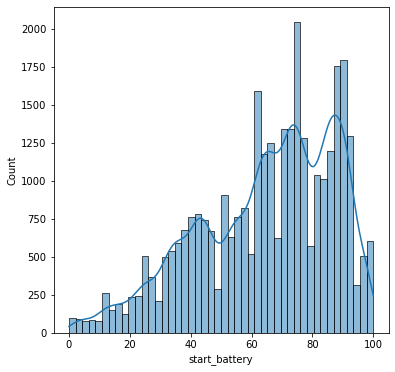

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.histplot(data=rentals, x='start_battery', kde=True)
plt.show()

## Duration of rentals

In [8]:
avg_rental_duration = f"Average rentals duration: {round(all_data['duration'].mean(), 2)} minutes"

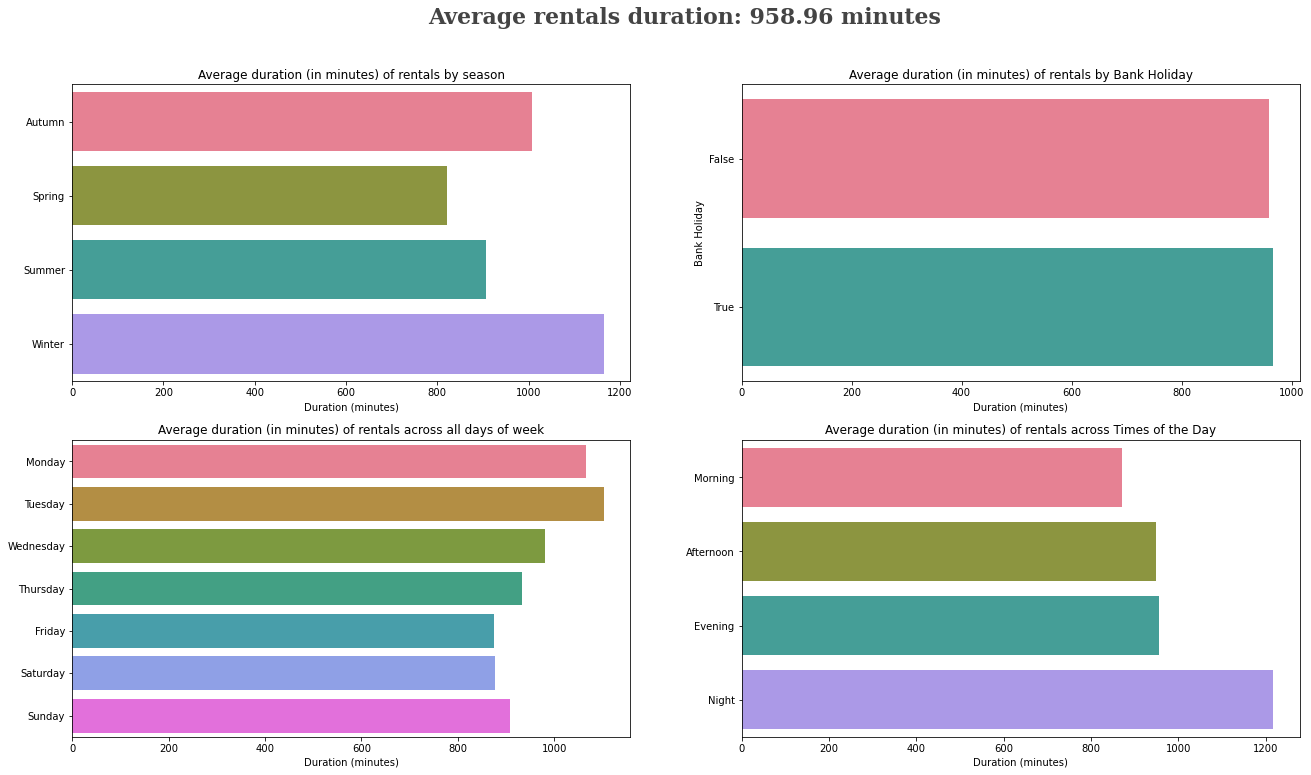

In [9]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(22, 12))

# fig.text(0.125,1.1, avg_rental_duration, fontfamily='serif',fontsize=14, fontweight='bold', color='#444444')
fig.text(0.35,0.95,avg_rental_duration,fontfamily='serif',fontsize=22,fontweight='bold',color='#444444')

season_rentduration = all_data.groupby(['season'])['duration'].mean()
sns.barplot(x=season_rentduration.values, y=season_rentduration.index, ax=ax[0][0], orient='h', palette='husl')
ax[0][0].set(xlabel='Duration (minutes)', ylabel='', title='Average duration (in minutes) of rentals by season')

day_of_week_rentduration = all_data.groupby(['dayofweek'])['duration'].mean()
sns.barplot(x=day_of_week_rentduration.values, y=day_of_week_rentduration.index, ci=None, ax=ax[1][0],
            order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], orient='h', palette='husl')
ax[1][0].set(xlabel='Duration (minutes)', ylabel='', title='Average duration (in minutes) of rentals across all days of week')

holiday_rentduration = all_data.groupby(['holiday'])['duration'].mean()
sns.barplot(x=holiday_rentduration.values, y=holiday_rentduration.index, ax=ax[0][1], orient='h', palette='husl')
ax[0][1].set(xlabel='Duration (minutes)', ylabel='Bank Holiday', title='Average duration (in minutes) of rentals by Bank Holiday')
# ax[0][1].bar_label(ax[0][1].containers[0])

timesofday_rentduration = all_data.groupby(['timesofday'])['duration'].mean()
sns.barplot(x=timesofday_rentduration.values, y=timesofday_rentduration.index, ax=ax[1][1],
            order=['Morning','Afternoon','Evening','Night'], orient='h', palette='husl')
ax[1][1].set(xlabel='Duration (minutes)', ylabel='', title='Average duration (in minutes) of rentals across Times of the Day')

plt.show()

We can spot a few patterns when in colder days (Autumn and Winter | Night), the duration of rentals on average is higher. It seems that, on average, customers stay longer with bikes on early days of the week (Monday, Tuesday and Wednesday). On the other hand, it does not seem to be a difference on average rentals duration on Bank Holidays.

## Total number of rentals

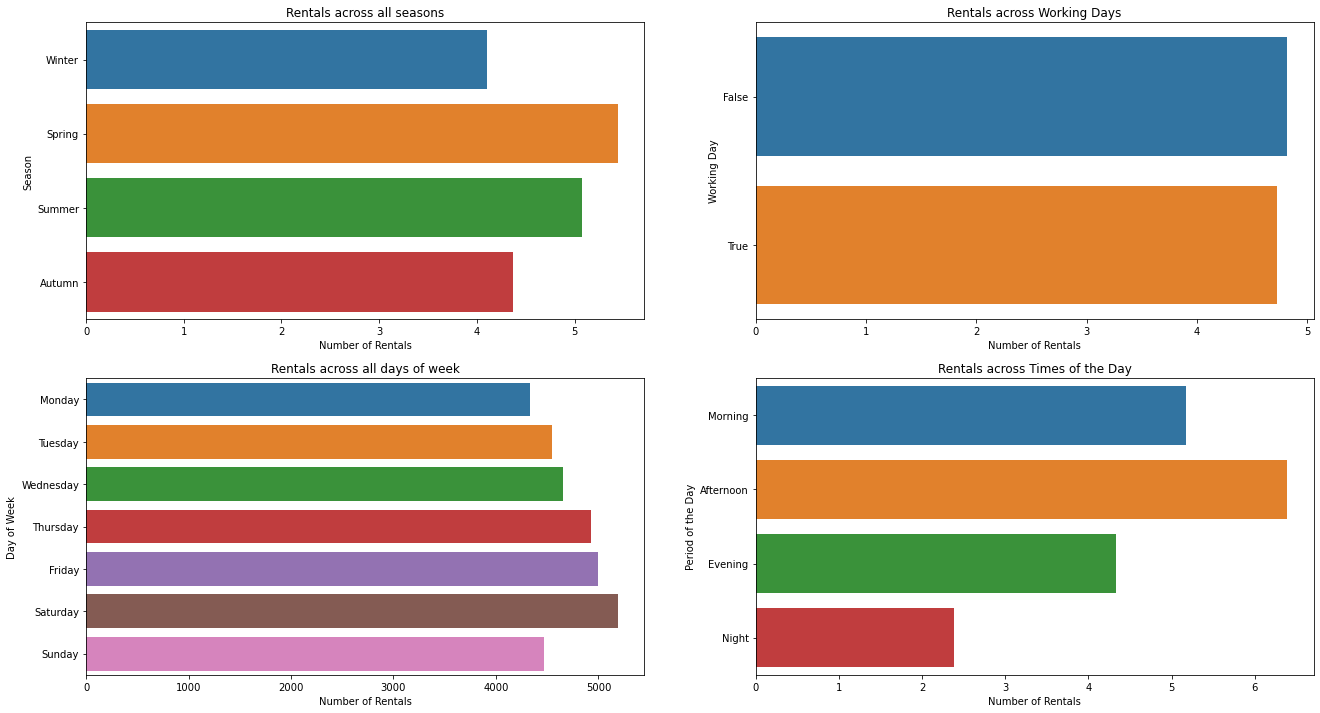

In [10]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(22, 12))

sns.barplot(data=hourly_rentals, 
            x='count', y='season', order=['Winter','Spring','Summer','Autumn'], ci=None, ax=ax[0][0])
ax[0][0].set(xlabel='Number of Rentals', ylabel='Season', title='Rentals across all seasons')

day_of_week = hourly_rentals.groupby('dayofweek')['count'].agg('sum').reset_index(name='count')
sns.barplot(data=day_of_week, x='count', y='dayofweek', ci=None, ax=ax[1][0],
            order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
ax[1][0].set(xlabel='Number of Rentals', ylabel='Day of Week', title='Rentals across all days of week')

sns.barplot(data=hourly_rentals, x='count', y='working_day', ci=None, ax=ax[0][1], orient='h')
# sns.lineplot(data=hourly_rentals , x="hour", y="count", hue="working_day", ax=ax[0][1], ci=None)
ax[0][1].set(xlabel='Number of Rentals', ylabel='Working Day', title='Rentals across Working Days')

sns.barplot(data=hourly_rentals, x='count', y='timesofday', ci=None, ax=ax[1][1],
            order=['Morning','Afternoon','Evening','Night'])
ax[1][1].set(xlabel='Number of Rentals', ylabel='Period of the Day', title='Rentals across Times of the Day')

plt.show()

As expected, in the Spring and Summer had more rentals than on Autumn and Winter as the weather impacts directly the number of rentals and those seasons usually have better weather. Also, the number of rentals is significant higher in the *Afternoon* followed by *Mornining*, *Evening* and then *Night*. Again, the number of rentals do not seem to have a significant difference on Weekends/Holidays.

As consequence of the duration of rentals being higher during early weekdays, we see that Thursday, Friday and Saturday have a higher flux of new rentals.

## Hourly number of rentals

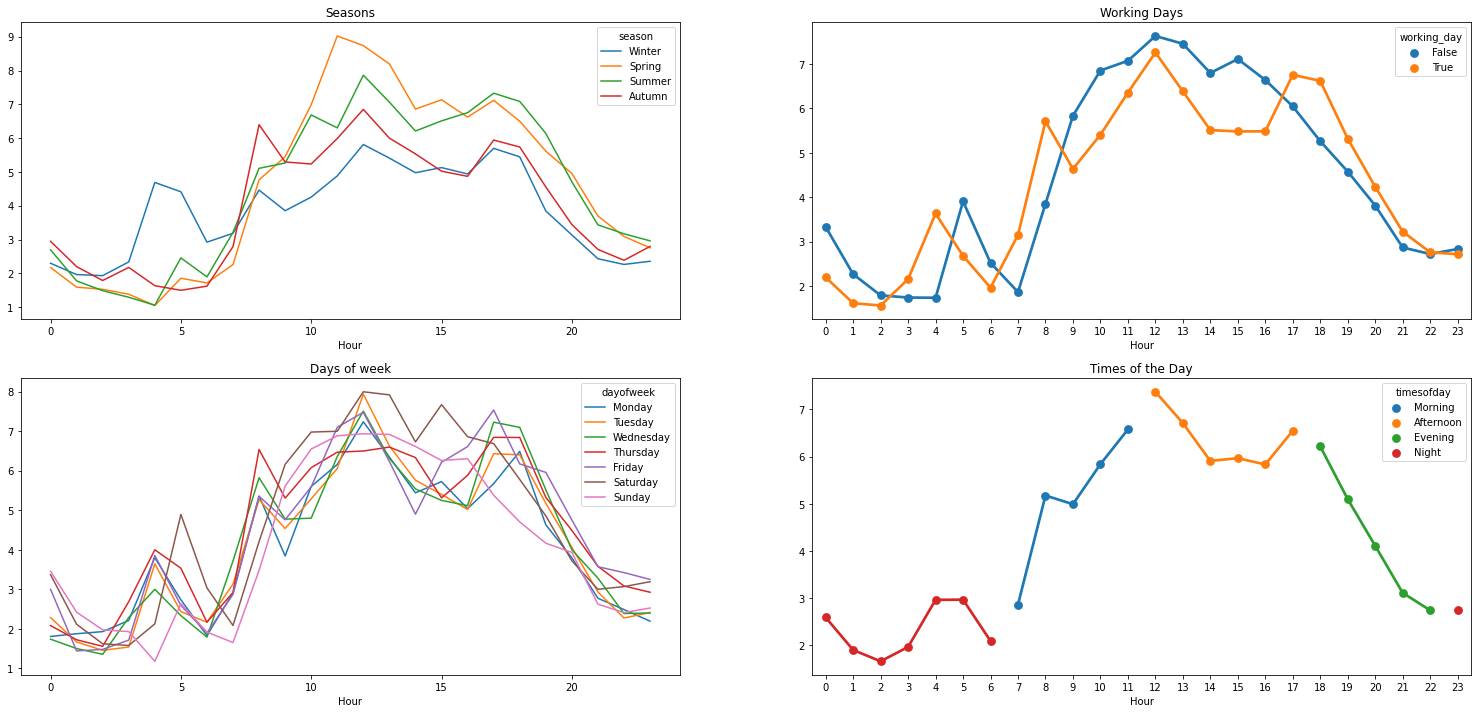

In [11]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(26, 12))

sns.lineplot(data=hourly_rentals, x='hour', y='count', hue='season', hue_order=['Winter','Spring','Summer','Autumn'], ax=ax[0][0], ci=None)
ax[0][0].set(xlabel='Hour', ylabel='', title='Seasons')

sns.lineplot(data=hourly_rentals, x='hour', y='count', hue='dayofweek', hue_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ax=ax[1][0], ci=None)
ax[1][0].set(xlabel='Hour', ylabel='', title='Days of week')

sns.pointplot(data=hourly_rentals, x="hour", y="count", hue="working_day", ax=ax[0][1], ci=None)
ax[0][1].set(xlabel='Hour', ylabel='', title='Working Days')

sns.pointplot(data=hourly_rentals, x='hour', y='count', hue='timesofday', hue_order=['Morning','Afternoon','Evening','Night'], ax=ax[1][1], ci=None)
ax[1][1].set(xlabel='Hour', ylabel='', title='Times of the Day')

plt.show()

When we plot the number o rentals on each hour of day, we notice that no discrepancy's found on different Seasons, Weekends/Holidays and even week days follow a similar pattern throughout the day.

## BoxPlot analyses

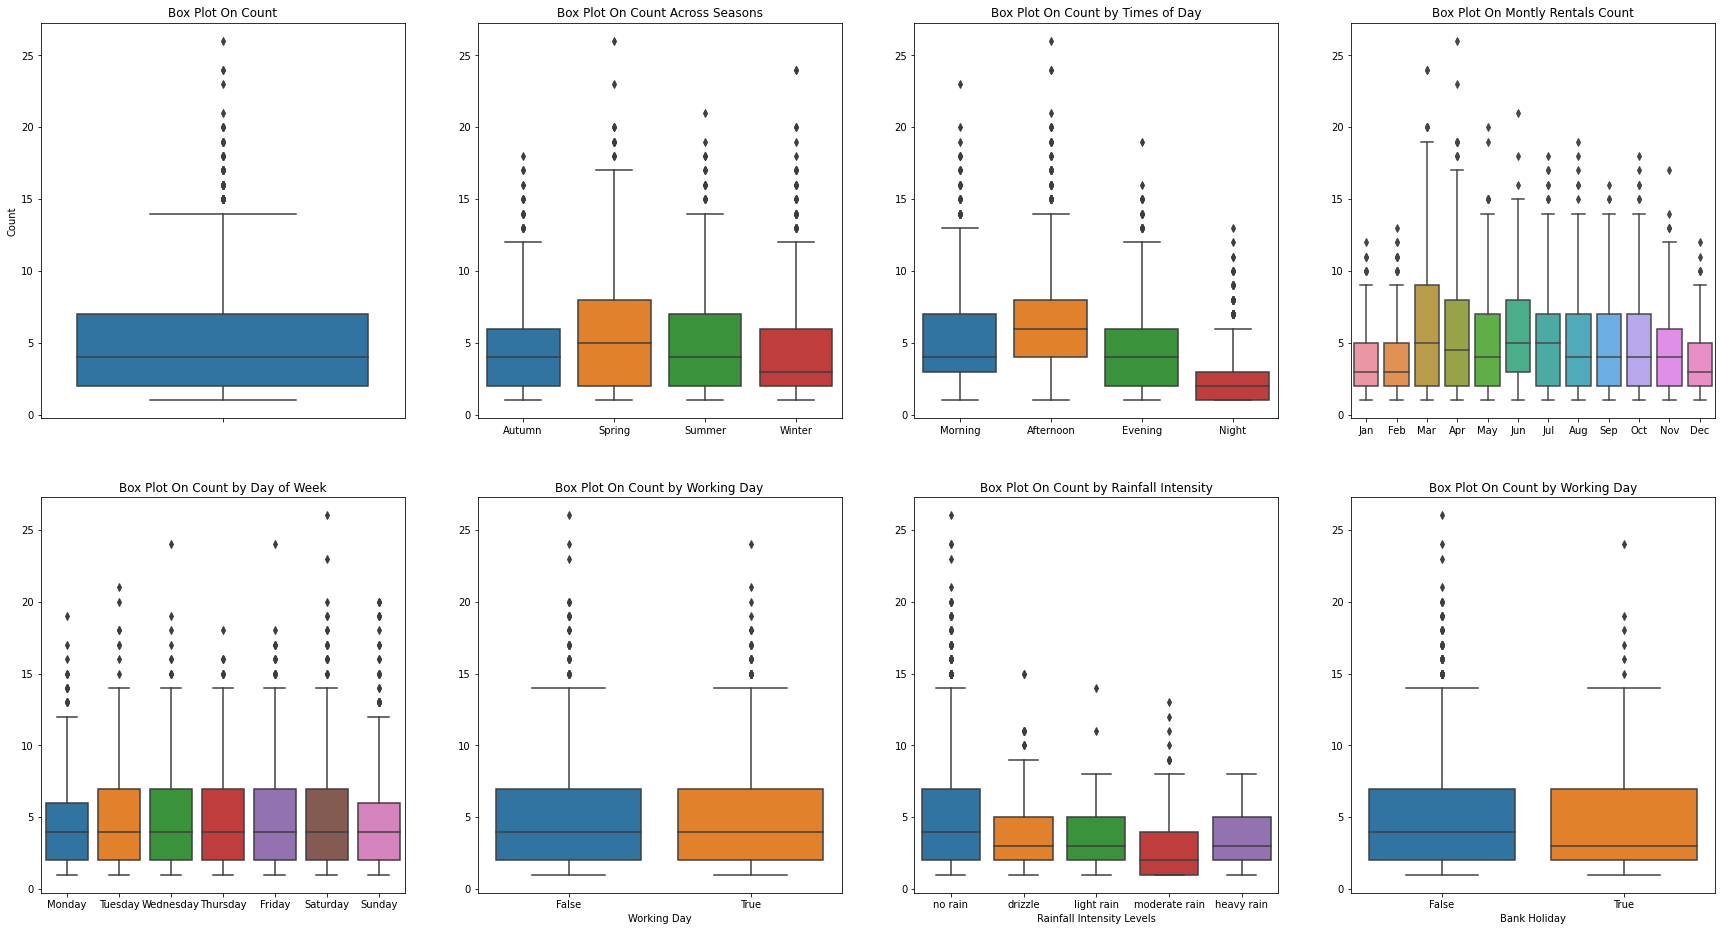

In [12]:
fig, axes = plt.subplots(nrows=2,ncols=4, figsize=(30, 16))

sns.boxplot(data=hourly_rentals,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=hourly_rentals,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=hourly_rentals,y="count",x="dayofweek",orient="v",ax=axes[1][0], 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.boxplot(data=hourly_rentals,y="count",x="working_day",orient="v",ax=axes[1][1])
sns.boxplot(data=hourly_rentals,y="count",x="timesofday",orient="v",ax=axes[0][2], order=['Morning', 'Afternoon', 'Evening', 'Night'])
sns.boxplot(data=hourly_rentals,y="count",x="rainfall_intensity",orient="v",ax=axes[1][2], 
            order=['no rain', 'drizzle', 'light rain', 'moderate rain', 'heavy rain'])

monthly_data = hourly_rentals[['month','count']].copy()
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
monthly_data['month_str'] = hourly_rentals['month'].map(lambda d : month_map[d])
sns.boxplot(data=monthly_data, x="month_str", y="count", orient="v",ax=axes[0][3], order=month_map.values())
sns.boxplot(data=hourly_rentals, x="holiday", y="count", orient="v",ax=axes[1][3])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='', ylabel='',title="Box Plot On Count Across Seasons")
axes[1][0].set(xlabel='', ylabel='',title="Box Plot On Count by Day of Week")
axes[1][1].set(xlabel='Working Day', ylabel='',title="Box Plot On Count by Working Day")
axes[0][2].set(xlabel='', ylabel='',title="Box Plot On Count by Times of Day")
axes[1][2].set(xlabel='Rainfall Intensity Levels', ylabel='',title="Box Plot On Count by Rainfall Intensity")
axes[0][3].set(xlabel='', ylabel='', title="Box Plot On Montly Rentals Count")
axes[1][3].set(xlabel='Bank Holiday', ylabel='', title="Box Plot On Count by Working Day")

plt.show()

### Main findings:

- Bikes are, on average, less rented on Bank Holidays. This could be because Moby Bikes have a subscription plan and this could impact if people subscribe to commute, for example.
- Apart from Moderate Rain, we do not see a big mean difference on Rainfall Intensity Levels.
- We already saw on above plots that in the Afternoon where most of the bikes are rented and the same pattern is reflected on the means values.
- Monthly average is also presenting some patterns that could indicate time series seasonality.

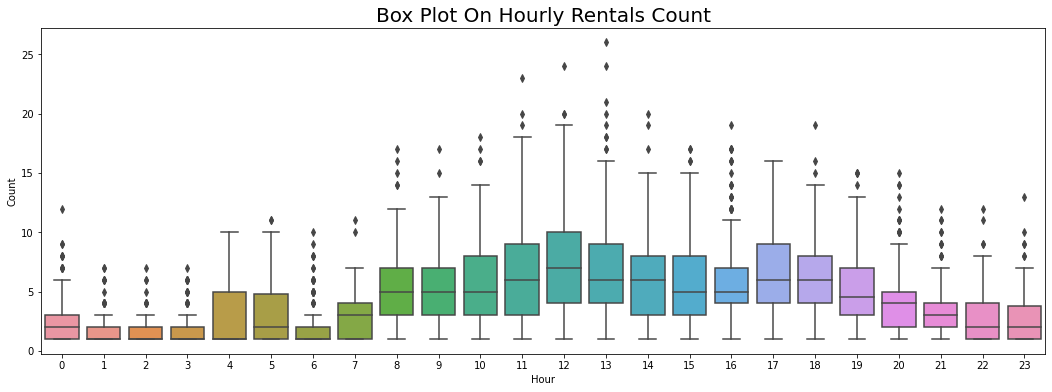

In [13]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(data=hourly_rentals, x="hour", y="count", orient="v",ax=ax)
ax.set(xlabel='Hour', ylabel='Count')
ax.set_title(fontsize=20, label="Box Plot On Hourly Rentals Count")
plt.show()

As demonstrated above by line plots and from the boxplot, in the afternoon bikes are more rented on average and in total. Hourly means have demonstrated being very scattered.


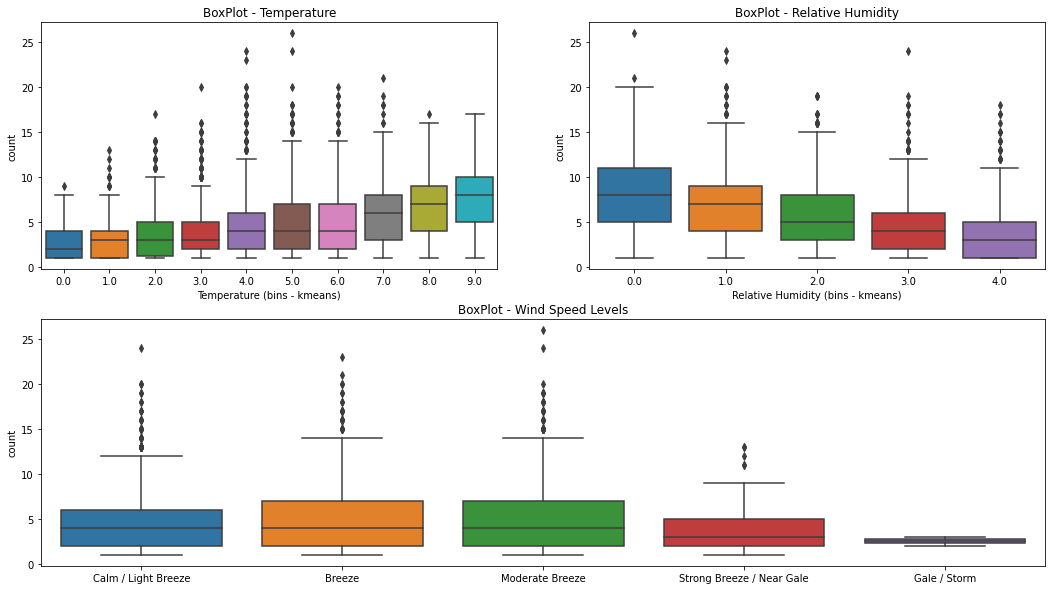

In [14]:
fig = plt.figure(figsize=(18,10))
gs = fig.add_gridspec(2, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, :])

sns.boxplot(data=hourly_rentals, x="temp_bin", y="count", orient="v",ax=ax0)
sns.boxplot(data=hourly_rentals, x="rhum_bin", y="count", orient="v",ax=ax1)
sns.boxplot(data=hourly_rentals, x="wind_speed_group", y="count", orient="v",ax=ax2,
            order=['Calm / Light Breeze', 'Breeze', 'Moderate Breeze', 'Strong Breeze / Near Gale','Gale / Storm'])

ax0.set(xlabel='Temperature (bins - kmeans)',title="BoxPlot - Temperature")
ax1.set(xlabel='Relative Humidity (bins - kmeans)',title="BoxPlot - Relative Humidity")
ax2.set(xlabel='',title="BoxPlot - Wind Speed Levels")

plt.show()

Weather features, as temperature and humidity, have visually mean differences and it makes sense when deciding to use a bike. Wind Speed seems to decrease usage on average only when it is strong and storms.

## Kruskal-Wallis H-test on categorical features

The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

- The samples are independent.
- Each sample is from a normally distributed population.
- The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

>*count* feature does not have normal distribution, using non-parametric Kruskal-Wallis H-test instead

In [15]:
# Defining a function to find the statistical relationship with all the categorical variables
def kruskal_test_categorical_features(df, target, cat_vars):
    from scipy.stats import kruskal

    # Creating an empty list of final selected predictors
    selected_predictors=[]
    
    print('##### Kruskal-Wallis H-test Results ##### \n')
    for predictor in cat_vars:
        cat_grouplist=df.groupby(predictor)[target].apply(list)
        kruskal_res = kruskal(*cat_grouplist) #  Kruskal-Wallis H-test
        
        # If the ANOVA P-Value is <0.05, that means we reject H0
        if (kruskal_res[1] < 0.05):
            print(predictor, 'is correlated with', target, '| p-value:', kruskal_res[1])
            selected_predictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', target, '| p-value:', kruskal_res[1])
    
    return(selected_predictors)

In [16]:
# Calling the function to check which categorical variables are correlated with target
cat_vars=\
    ['season', 'hour', 'holiday', 'working_day', 'peak', 'timesofday', 'rainfall_intensity', 'dayofweek', 'temp_bin', 'rhum_bin', 'wind_speed_group', 'wind_bft']
kruskal_test_categorical_features(df=hourly_rentals, target='count', cat_vars=cat_vars)

##### Kruskal-Wallis H-test Results ##### 

season is correlated with count | p-value: 8.63495056716637e-31
hour is correlated with count | p-value: 0.0
holiday is NOT correlated with count | p-value: 0.41942955527875236
working_day is NOT correlated with count | p-value: 0.15009923596080033
peak is correlated with count | p-value: 1.0653072805746697e-28
timesofday is correlated with count | p-value: 0.0
rainfall_intensity is correlated with count | p-value: 2.880235646944005e-24
dayofweek is correlated with count | p-value: 8.435955855048016e-05
temp_bin is correlated with count | p-value: 2.7496476440768065e-149
rhum_bin is correlated with count | p-value: 3.3935384467291044e-232
wind_speed_group is correlated with count | p-value: 4.413616687338811e-11
wind_bft is correlated with count | p-value: 2.0407926746235298e-14


['season',
 'hour',
 'peak',
 'timesofday',
 'rainfall_intensity',
 'dayofweek',
 'temp_bin',
 'rhum_bin',
 'wind_speed_group',
 'wind_bft']

## Correlation Matrix

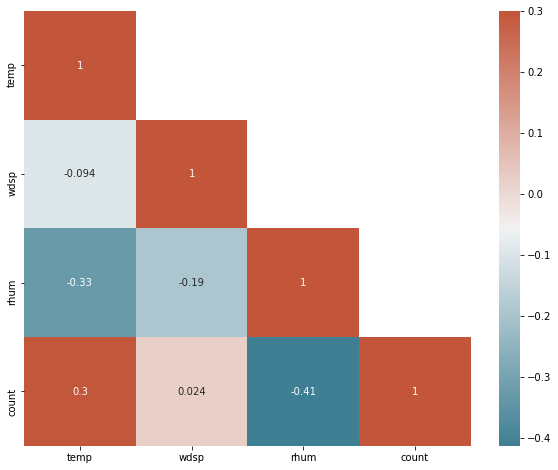

,Correlation to the target
temp,0.297142
wdsp,0.023791
rhum,-0.413528


In [17]:
corrMatt = hourly_rentals[['temp','wdsp','rhum','count']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
cmap = sns.diverging_palette(220, 20, as_cmap=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corrMatt, mask=mask,vmax=.3, annot=True, ax=ax, cmap=cmap)
plt.show()

df1Corr=pd.DataFrame(corrMatt.drop('count').unstack().sort_values(ascending=False)['count'],columns=['Correlation to the target'])
df1Corr.style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

## Distribution of numerical features

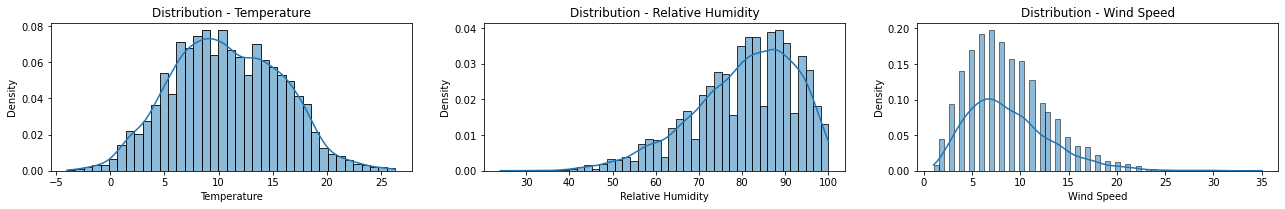

In [18]:
fig = plt.figure(figsize=(22,6))
gs = fig.add_gridspec(2, 3)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

sns.histplot(hourly_rentals['temp'],ax=ax0, stat='density', kde=True)
sns.histplot(hourly_rentals['rhum'],ax=ax1, stat='density', kde=True)
sns.histplot(hourly_rentals['wdsp'],ax=ax2, stat='density', kde=True)

ax0.set(xlabel='Temperature',title="Distribution - Temperature")
ax1.set(xlabel='Relative Humidity',title="Distribution - Relative Humidity")
ax2.set(xlabel='Wind Speed',title="Distribution - Wind Speed")

plt.show()

## Relations between Numerical Features and Target variable

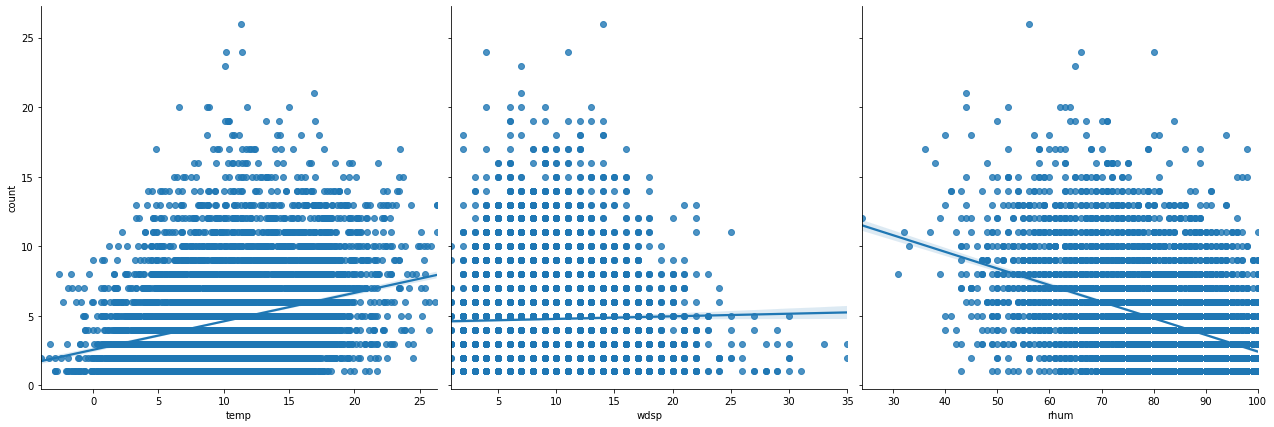

In [19]:
sns.pairplot(hourly_rentals, 
             x_vars=['temp','wdsp','rhum'],
             dropna=True, 
             y_vars='count', 
             height=6, 
             kind="reg", 
             palette='Set1')
plt.show()

Temperature and Relative Humidity show a strong correlation with Rentals Count (positive and negative, respectively) but Wind Speed does not seem to be correlated with Rentals Count. 

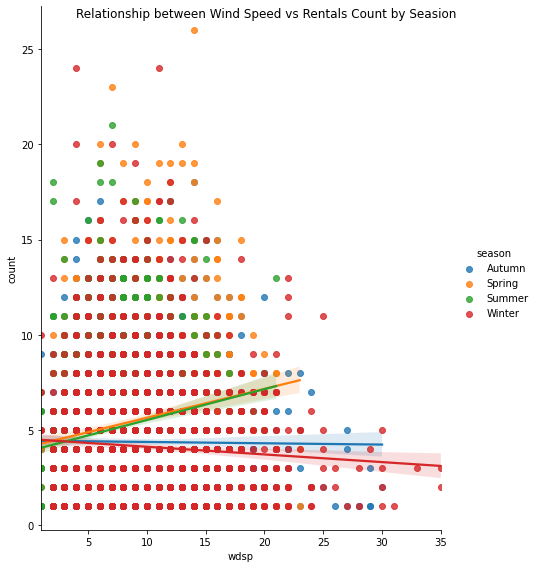

In [20]:
pp = sns.pairplot(hourly_rentals, 
             x_vars='wdsp',
             dropna=True, 
             y_vars='count', height=8, aspect=0.8, kind="reg", hue='season')
pp.fig.suptitle("Relationship between Wind Speed vs Rentals Count by Seasion")
plt.show()

If we plot the relationship by Season we can see that Wind Speed is correlated but depending on the Season is positive or negative. Which makes sense since on Autumn and Winter, as it is colder and temperature is normally low, Rentals decrease as the Wind Speed increases. In the Spring and Summer, because the temperature are on average higher the wind speed we see a different effect (positive correlation).



## Outlier Analysis

### Unusual Observations (Outliers) and High Leverage Observations
- We have a few outliers but not sure if they can be treated as inacurates as they capture the data.
- High Leverage Observations are unusual values on the predictors that can dramatically affect the model. In a regression analysis, single observations can have a strong influence on the results of the model.

Influencial Points (not all unusual observations have much of an impact on the model) - https://www.kirenz.com/post/2021-11-14-linear-regression-diagnostics-in-python/linear-regression-diagnostics-in-python/

In [21]:
expr = \
     """ count ~ temp_bin + wind_speed_group + rhum_bin + rainfall_intensity + holiday + timesofday"""
y_train, X_train = dmatrices(expr, hourly_data, return_type = 'dataframe')
nb_training_results = sm.GLM(y_train, X_train, family = sm.families.NegativeBinomial(alpha = 1)).fit(maxiter=5000, method='nm', cov_type='HC3')

We can use influence plots to identify observations in our independent variables which have “unusual” values in comparison to other values.

Influence plots show the (externally) studentized residuals vs. the leverage of each observation:

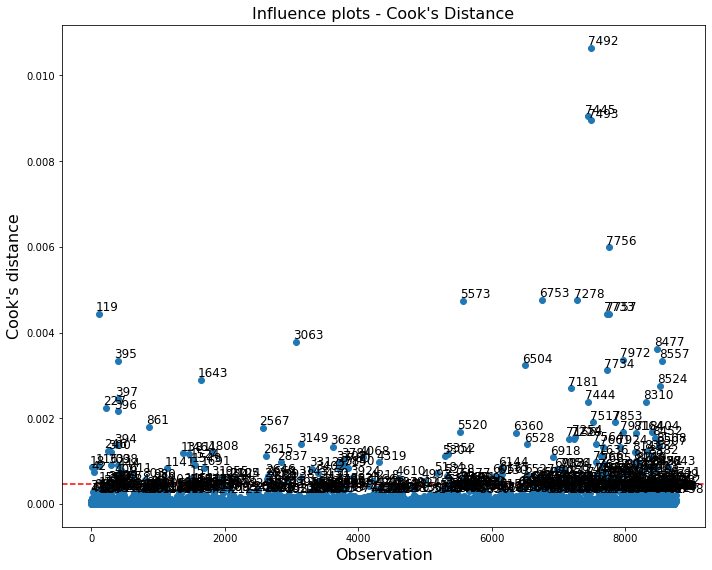

In [22]:
infl = nb_training_results.get_influence(observed=False)
fig, ax = plt.subplots(figsize=(10, 8))
infl.plot_index(y_var="cooks", threshold=3 * infl.cooks_distance[0].mean(), 
                ax=ax, title="Influence plots - Cook's Distance")
fig.tight_layout(pad=1.0)
plt.axhline(4 / hourly_data.shape[0], color='r', linestyle='--')
plt.show()

A data point that has a large value for Cook’s Distance indicates that it strongly influences the fitted values. A general rule of thumb is that any point with a Cook’s Distance over 4/n (where n is the total number of data points) is considered to be an outlier.

In [23]:
# obtain Cook's distance 
model_cooksd = infl.cooks_distance[0]
threshold_c = 4 / hourly_data.shape[0]
out_d = model_cooksd > threshold_c
subset_data = hourly_data[~out_d]
print(f'Number of possible outliers: {hourly_data.shape[0] - subset_data.shape[0]}')

Number of possible outliers: 180


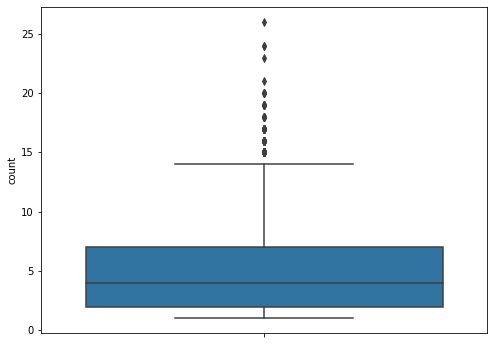

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=hourly_rentals,
            y="count",
            orient="v",ax=ax)
plt.show()

In [25]:
hourlyDataOutliers = hourly_rentals[hourly_rentals['count'] > 14]
hourlyDataWithoutOutliers = hourly_rentals[hourly_rentals['count'] <= 14]
    
print(f"Outliers (#): {round(hourlyDataOutliers.shape[0], 2)}")
print(f"Outliers (%): {round((hourlyDataOutliers.shape[0] / hourly_rentals.shape[0])*100, 2)}%")

Outliers (#): 93
Outliers (%): 1.34%


In [26]:
hourlyDataOutliers['holiday'].value_counts()

False    87
True      6
Name: holiday, dtype: int64

In [27]:
hourlyDataOutliers['working_day'].value_counts(normalize=True)

False    0.505376
True     0.494624
Name: working_day, dtype: float64

In [28]:
hourlyDataOutliers['season'].value_counts()

Spring    45
Winter    21
Summer    18
Autumn     9
Name: season, dtype: int64

Unusual observations do not seem to be related with *Holiday* nor Weekends (*Working_Day*). 

In [29]:
daily_count = hourly_rentals.groupby('date')['count'].sum().reset_index()
daily_count_no_outliers = hourlyDataWithoutOutliers.groupby('date')['count'].sum().reset_index()

In [30]:
mean_daily = daily_count['count'].mean()
std_dev_daily = daily_count['count'].std()
slice_daily = mean_daily + (2*std_dev_daily)
daily_count[daily_count['count'] > slice_daily]

,date,count
6,2021-03-07,157
16,2021-03-17,171
18,2021-03-19,151
19,2021-03-20,148
33,2021-04-03,155
47,2021-04-17,153
54,2021-04-24,163
55,2021-04-25,168
138,2021-07-17,162
144,2021-07-23,154


In [31]:
daily_count.describe()

,count
count,364.000000
mean,90.986264
std,27.873234
min,14.000000
25%,73.000000
50%,90.000000
75%,111.000000
max,171.000000


In [32]:
print(f"Mean of daily rentals = {round(daily_count['count'].mean(), 2)}")
print(f"Mean of daily rentals without Outliers = {round(daily_count_no_outliers['count'].mean(), 2)}")

Mean of daily rentals = 90.99
Mean of daily rentals without Outliers = 86.67


In [33]:
hourlyDataOutliers = hourlyDataOutliers.join(daily_count.set_index('date'), on='date', lsuffix='_hour', rsuffix='_day')

In [34]:
outliers_df = hourlyDataOutliers[hourlyDataOutliers['count_day'] > 110].sort_values(by='count_day', ascending=False)
outliers_df.head()

,date,hour,rain,temp,rhum,wdsp,day,month,year,holiday,...,peak,timesofday,rainfall_intensity,wind_bft,wind_speed_group,temp_r,temp_bin,rhum_bin,count_hour,count_day
286,2021-03-17,11,0.0,8.7,81,12,17,3,2021,True,...,False,Morning,no rain,4,Moderate Breeze,9,4.0,3.0,18,171
287,2021-03-17,12,0.0,10.3,71,9,17,3,2021,True,...,False,Afternoon,no rain,3,Breeze,10,4.0,2.0,19,171
288,2021-03-17,13,0.0,11.4,66,11,17,3,2021,True,...,False,Afternoon,no rain,4,Moderate Breeze,11,5.0,1.0,24,171
289,2021-03-17,14,0.0,11.9,60,12,17,3,2021,True,...,False,Afternoon,no rain,4,Moderate Breeze,12,5.0,1.0,17,171
290,2021-03-17,15,0.0,12.8,49,10,17,3,2021,True,...,False,Afternoon,no rain,3,Breeze,13,5.0,0.0,15,171


In [35]:
hourlyDataOutliers.to_csv('../data/interim/outliers.csv')

In [36]:
all_data = pd.read_csv('../data/processed/all_data.csv')
all_data[["date"]] = all_data[["date"]].apply(pd.to_datetime)
all_data['month_year'] = pd.to_datetime(all_data['date']).dt.to_period('M')
df_month = all_data.groupby("month_year").agg({"bikeid": pd.Series.nunique})
df_month

,bikeid
month_year,
2021-03,94
2021-04,79
2021-05,78
2021-06,78
2021-07,77
2021-08,72
2021-09,75
2021-10,75
2021-11,73


## Monthly Data

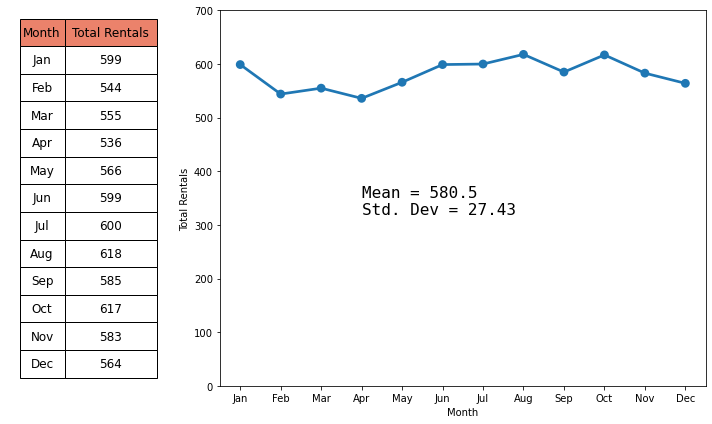

In [37]:
monthly_data = hourly_rentals.groupby('month')['count'].agg('count').reset_index(name='count')
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
monthly_data['monthly_data_str'] = monthly_data['month'].map(lambda d : month_map[d])
monthly_stats = f"Mean = {round(monthly_data['count'].mean(), 2)} \nStd. Dev = {round(monthly_data['count'].std(), 2)}"
monthly_data = monthly_data[['monthly_data_str', 'count']]
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3]}, figsize=(10,6), tight_layout=True)
ax[0].axis('off')
ax[0].axis('tight')
table = ax[0].table(cellText=monthly_data.values, colLabels=['Month','Total Rentals'], cellLoc='center', loc='center', colColours =["#eb826b"] * 2)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(monthly_data.columns)))) 
table.scale(3,2)
monthly_plot = sns.pointplot(x=monthly_data["monthly_data_str"], y=monthly_data["count"], ax=ax[1])
ax[1].set(ylim=(0,700), xlabel='Month', ylabel='Total Rentals')
monthly_plot.annotate(monthly_stats, xy=(3, 320), fontsize=16, fontfamily='monospace')
fig.tight_layout()
plt.show()

### Distribution across Times of the Day

In [74]:
def labels_zeros(df):
    zero_values = len(df[df['count'] == 0])
    stats_df = df['count'].agg(['mean','var','std'])
    return f"Zeros: {round((zero_values/df.shape[0])*100, 2)}% \n" + \
        f"Mean = {round(stats_df['mean'], 2)} \nVariance = {round(stats_df['var'], 2)} \nStd. Dev = {round(stats_df['std'], 2)} \n" +\
        f"n = {df.shape[0]}"

df_night = hourly_data[hourly_data['timesofday'] == 'Night']
df_morn = hourly_data[hourly_data['timesofday'] == 'Morning']
df_aft = hourly_data[hourly_data['timesofday'] == 'Afternoon']
df_eve = hourly_data[hourly_data['timesofday'] == 'Evening']

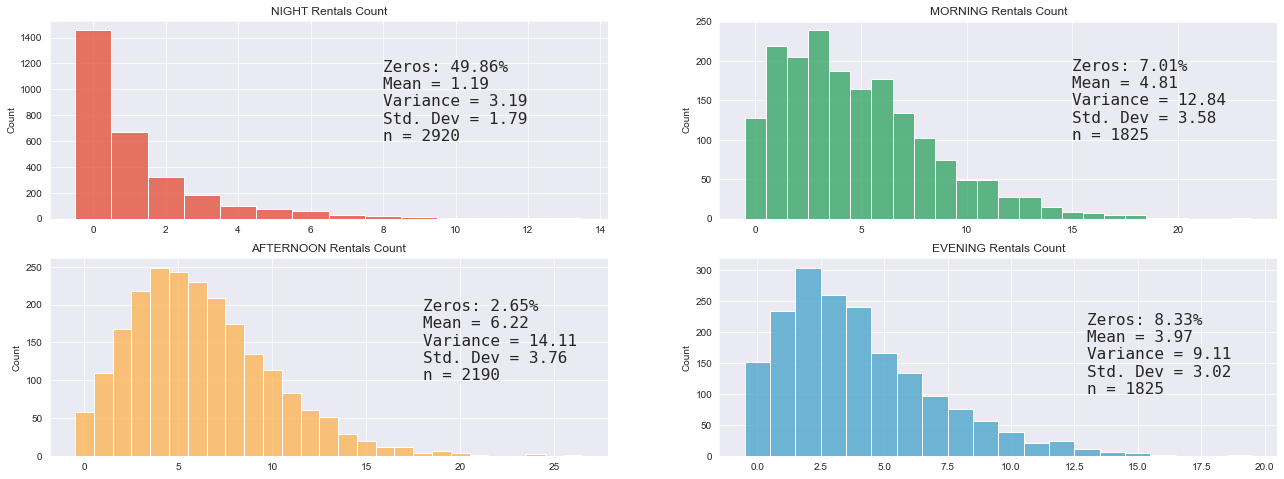

In [81]:
fig = plt.figure(figsize=(22,8))
gs = fig.add_gridspec(2, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

night_plot = sns.histplot(data=df_night, x='count', ax=ax0, stat='count', discrete=True, color='#e34a33')
morning_plot = sns.histplot(data=df_morn, x='count', ax=ax1, stat='count', discrete=True, color='#2ca25f')
afternoon_plot = sns.histplot(data=df_aft, x='count', ax=ax2, stat='count', discrete=True, color='#feb24c')
evening_plot = sns.histplot(data=df_eve, x='count', ax=ax3, stat='count', discrete=True, color='#43a2ca')

night_plot.annotate(labels_zeros(df_night), xy=(8, 600), fontsize=16, fontfamily='monospace')
label_stats = labels_zeros(df_morn)
morning_plot.annotate(labels_zeros(df_morn), xy=(15, 100), fontsize=16, fontfamily='monospace')
label_stats = labels_zeros(df_aft)
afternoon_plot.annotate(labels_zeros(df_aft), xy=(18, 100), fontsize=16, fontfamily='monospace')
label_stats = labels_zeros(df_eve)
evening_plot.annotate(labels_zeros(df_eve), xy=(13, 100), fontsize=16, fontfamily='monospace')

ax0.set(xlabel='',title="NIGHT Rentals Count")
ax1.set(xlabel='',title="MORNING Rentals Count")
ax2.set(xlabel='',title="AFTERNOON Rentals Count")
ax3.set(xlabel='',title="EVENING Rentals Count")

plt.show()

## None rentals (zeroes)

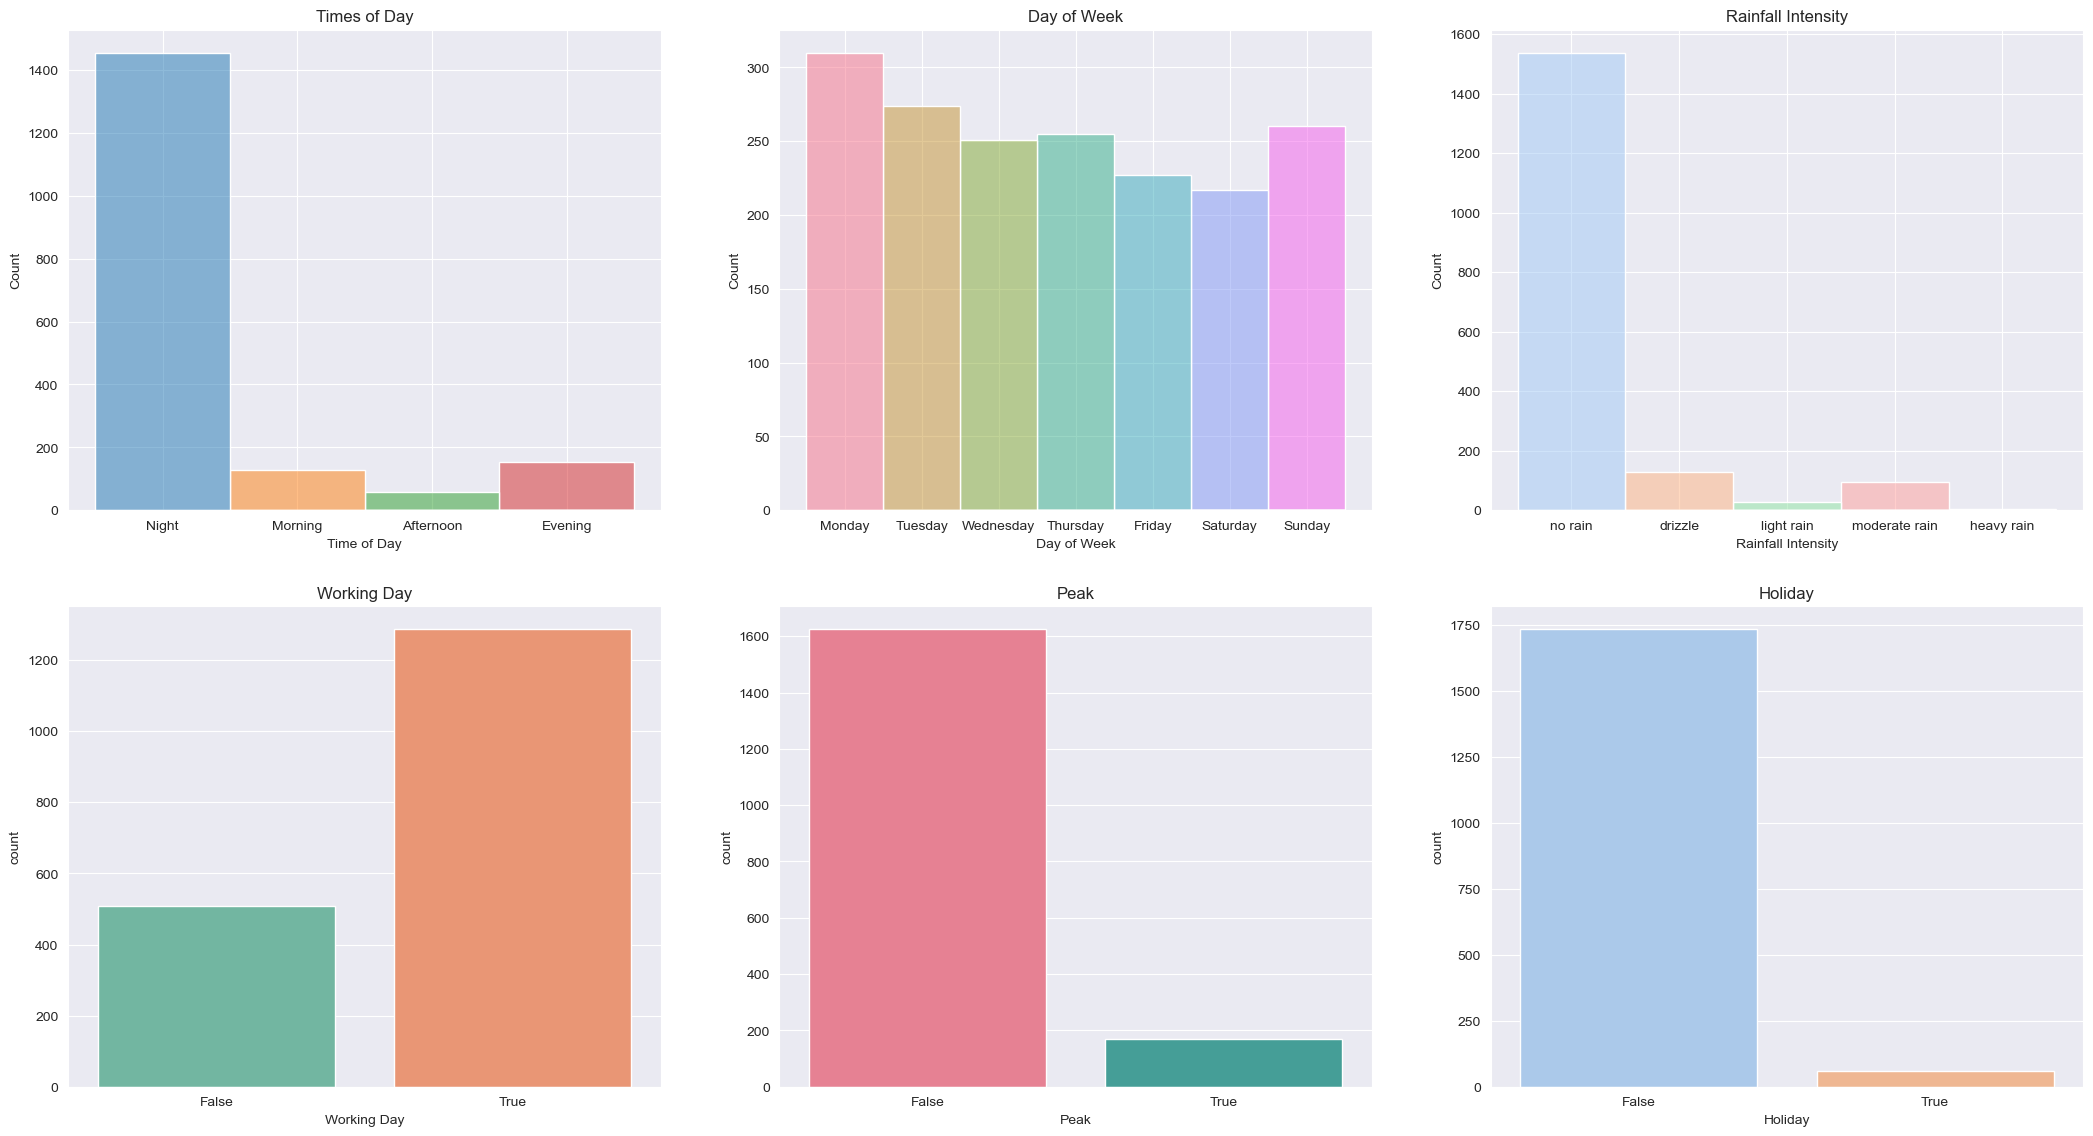

In [44]:
zerocnt_df = hourly_data[hourly_data['count'] == 0].copy()
fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(26,14), dpi=100)

zerocnt_df['timesofday'] = pd.Categorical(zerocnt_df['timesofday'],['Night','Morning','Afternoon','Evening'])
zerocnt_df['rainfall_intensity'] = pd.Categorical(zerocnt_df['rainfall_intensity'],['no rain','drizzle','light rain','moderate rain','heavy rain'])
zerocnt_df['dayofweek'] = pd.Categorical(zerocnt_df['dayofweek'],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

sns.histplot(data=zerocnt_df, x='timesofday', stat='count', ax=axes[0][0], hue='timesofday', palette='tab10', legend=False)
sns.histplot(data=zerocnt_df, x='dayofweek', stat='count', ax=axes[0][1], hue='dayofweek', palette='husl', legend=False)
sns.histplot(data=zerocnt_df, x='rainfall_intensity', stat='count', ax=axes[0][2], hue='rainfall_intensity', palette='pastel', legend=False)
axes[0][0].set(xlabel='Time of Day',title="Times of Day")
axes[0][1].set(xlabel='Day of Week',title="Day of Week")
axes[0][2].set(xlabel='Rainfall Intensity',title="Rainfall Intensity")

sns.countplot(data=zerocnt_df, x='working_day', ax=axes[1][0], palette='Set2')
sns.countplot(data=zerocnt_df, x='peak', ax=axes[1][1], palette='husl')
sns.countplot(data=zerocnt_df, x='holiday', ax=axes[1][2], palette='pastel')
axes[1][0].set(xlabel='Working Day',title="Working Day")
axes[1][1].set(xlabel='Peak',title="Peak")
axes[1][2].set(xlabel='Holiday',title="Holiday")

plt.show()

In [50]:
houlyTM = hourly_data[['date','hour','count']].copy()
# houlyTM = hourly_rentals[['date','hour','count']].copy()
houlyTM['datetime'] = pd.to_datetime(houlyTM.date) + pd.to_timedelta(houlyTM.hour, unit='h')
houlyTM.set_index('datetime', inplace=True)
houlyTM.drop(houlyTM.tail(25).index,inplace=True)

### Considerations
- Count has a fixed range due to limitation on bikes available. (e.g. we cannot have more than 30 rentals if Moby Bikes only has 30 bikes available and to a new rental begins the bike needs to become available (current rental finished))
- The duration of rentals is relevant and directly impacts the number of rentals per day.
- Because we have a limited range of occurence on our target feature, decisions trees can be applied as they can only predict within the training range.
- Hourly data requires an approach which can count with autocorrelation. Temperature, Humidity and Wind Speed are not randomly throughout the hours. If one hour we have a temperature of 25C, on the next hour is very likely that temperature will be closed to that. (time series?)
- Capturing the relationship on these variables as continuous can be hard for machine learning algorithms as the range is to high. Temperature of 13.4C and 13.9C or 13C and 15C, are practically the same if you think about deciding whether to go bicicling or not. The same rule applies for humidity and wind speed. Transforming these variables into categoricals can provide more relevance to the algorithms.

```python
# Stacking Random Forest and GBM
rf_pred = predict_on_test_set(rf_model, rf_cols)
gbm_pred = predict_on_test_set(gbm_model, gbm_cols)
# taking weighted average of output from two models
y_pred = np.round(.20*rf_pred + .80*gbm_pred)
```
- Consider transforming all features into categories or merge all into one (e.g. good weather = high temperature + weak wind speed + light or no rain). 
```python
df['ideal'] = df[['temp', 'windspeed']].apply(lambda x: (0, 1)[x['temp'] > 27 and x['windspeed'] < 30], axis = 1)
df['sticky'] = df[['humidity', 'workingday']].apply(lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], axis = 1)
```

- If we take the log(count), RMSLE can be computed with:
```python
def get_rmsle(y_pred, y_actual):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)
```

<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini